In [1]:
import os
import sys
import warnings; warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import scipy.stats as ss

import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In [2]:
# добавляем в sys.path директорию со скриптами
src_dir = os.path.join(os.getcwd(), '..', 'ocp')
sys.path.append(src_dir)

In [3]:
# загружаем необходимые скрипты
from data.loading import load_data, load_obj
from data.saving import save_obj
from data.splitting import train_holdout_split, predefined_cv_strategy
from features.stats import tconfint_mean
from plotting import plot_valid_curve

from models.preprocessing import PandasSimpleImputer

%load_ext autoreload
%autoreload

# задаем константы
SEED = 26

# Загрузка данных

In [4]:
train, test, numerical, categorical = load_data('../data/processed')

In [5]:
categorical_idxs = [train.columns.get_loc(c) for c in categorical]

In [6]:
(X, X_train, X_holdout, 
 y, y_train, y_holdout, 
 stratify) = train_holdout_split(train, random_state=SEED)

In [7]:
cv = predefined_cv_strategy(X_train, stratify, random_state=SEED)

In [8]:
models = load_obj('../data/models_dictionary/models_baseline.pkl')

In [9]:
selected_models = ['XGBClassifier', 'CatBoostClassifier']

# Подбор гиперпараметров препроцессинга

In [10]:
def write_gsearch_results(selected_models, X, y, param_grid, param_key):
    # для каждой выбранной модели
    for model in selected_models:

        # выбираем соответствующий ей пайплайн
        pipe = models[model]['pipe']

        # производим поиск по сетке
        gsearch = GridSearchCV(estimator=pipe, param_grid=param_grid,
                               scoring='roc_auc', cv=cv, 
                               return_train_score=True, n_jobs=-1, verbose=1)
        
        # если моделью является CatBoost
        if model == 'CatBoostClassifier':
            # передаем в параметры обучения индексы категориальных переменных
            fit_params = {'model__cat_features': categorical_idxs,
                          'model__verbose': False}
            # передаем созданные параметры обучения в метод fit
            gsearch.fit(X_train, y_train, **fit_params)
        else:
            gsearch.fit(X_train, y_train)

        # записываем результаты под ключом param_key
        # в соответствующую ветку модели
        models[model][param_key] = gsearch.cv_results_

In [11]:
def plot_gsearch_results(selected_models, param_grid_name, param_key=None, figsize=(20, 5)):

    if param_key is None:
        param_key = param_grid_name.split('__')[-1]

    fig, axes = plt.subplots(nrows=1, ncols=len(selected_models), figsize=figsize)

    for idx, model in enumerate(selected_models):
        
        try:
            ax = axes[idx]
        except TypeError:
            ax = axes

        results = models[model][param_key]
        param_values = np.array(results['param_' + param_grid_name].data, dtype='float64')
        train_scores_mean = results['mean_train_score']
        train_scores_std = results['std_train_score']
        test_scores_mean = results['mean_test_score']
        test_scores_std = results['std_test_score']

        plot_valid_curve(param_values, 
                         train_scores_mean, train_scores_std, 
                         test_scores_mean, test_scores_std, 
                         title=model, ax=ax, xlabel=param_key)

    plt.tight_layout();

In [12]:
def print_statistics(selected_models, param_key):
    for model in selected_models:
        print(f'{model}:')
        before = models[model]['actual']
        
        results = pd.DataFrame(models[model][param_key]).sort_values('rank_test_score').head(3)

        for i, row in enumerate(results.iterrows(), 1):
            
            row = row[1]
            cols = [col for col in row.index if '_test_score' in col][:-3]

            params = row['params']
            after = row[cols].values.flatten().astype('float64')
            pvalue = ss.ttest_rel(before, after)[1]

            # печатаем статистики полученных оценок
            model_message = f'Params №{i}: '
            margin = ' ' * len(model_message)
            message = (model_message 
                      + f'params: {params}\n'
                      + margin
                      + f'cv-scores before: {np.round(before, 4)}, shapiro_pvalue = {ss.shapiro(before)[1]:.2f}\n' 
                      + margin 
                      + f'cv-scores after : {np.round(after, 4)}, shapiro_pvalue = {ss.shapiro(after)[1]:.2f}\n'
                      + margin
                      + f'scores mean: before - {before.mean():.4f}, now - {after.mean():.4f}\n'
                      + margin 
                      + f'scores 0.95 confint: before - {tconfint_mean(before)}, now - {tconfint_mean(after)}\n'
                      + margin 
                      + f'scores 0.95 confint for diff: {tconfint_mean(after - before)}\n'
                      + margin
                      + f'pvalue for ttest_rel = {pvalue:.2f}\n')
            print(message)

## Порог укрупнения для категориальных переменных

Осуществим подбор порога укрупнения для категориальных переменных, посмотрим соответствующие кривые обучения и валидации, а также выведем некоторые статистики по полученным cv-оценкам, далее, на основании графиков и полученных статистик, выберем подходящие значения параметра. Данная схема будет использоваться в дальнейшем для подбора всех остальных параметров.

In [ ]:
# вычислим пороги укрупнения, учитывая тот факт, что в цикле
# кросс-валидации число строк в обучении равно 4/5 от изначального 
tols = np.round(np.arange(2, 32, 2) / (X_train.shape[0] * (4/5)), 5)

# задаем сетку для поиска
param_grid = {'preprocessor__cat__rcg__tol': tols}

# производим поиск по сетке и записываем результаты
# кросс-валидации в словарь models по соответствующему ключу
write_gsearch_results(selected_models, X_train, y_train, param_grid, 'tol')

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  3.9min finished


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.8min finished


In [ ]:
save_obj(models, '../data/models_dictionary/models_tol.pkl')

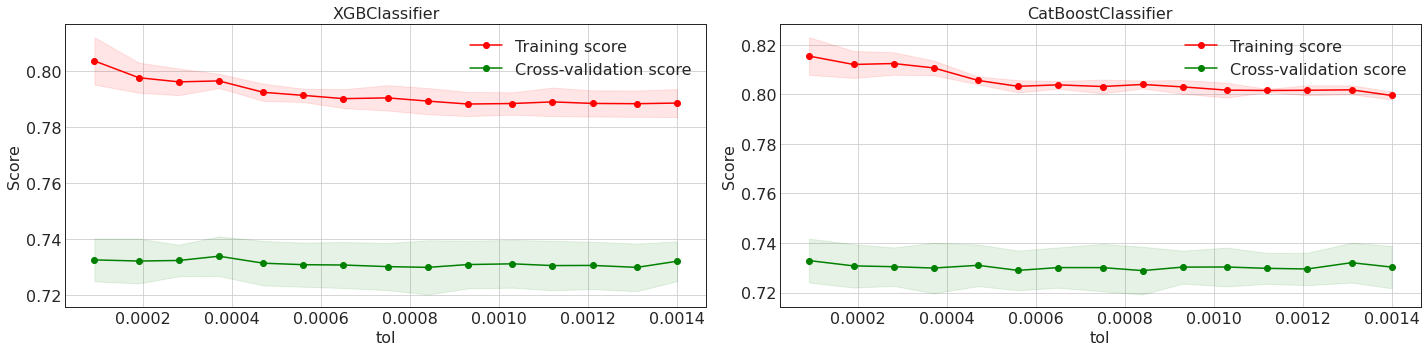

In [ ]:
plot_gsearch_results(selected_models, 'preprocessor__cat__rcg__tol')

In [ ]:
print_statistics(selected_models, 'tol')

XGBClassifier:
Params №1: params: {'preprocessor__cat__rcg__tol': 0.00037}
           cv-scores before: [0.7284 0.7312 0.737  0.7411 0.7162], shapiro_pvalue = 0.77
           cv-scores after : [0.7326 0.7333 0.7378 0.7434 0.7218], shapiro_pvalue = 0.80
           scores mean: before - 0.7308, now - 0.7338
           scores 0.95 confint: before - [0.719  0.7426], now - [0.7239 0.7436]
           scores 0.95 confint for diff: [0.0006 0.0054]
           pvalue for ttest_rel = 0.03

Params №2: params: {'preprocessor__cat__rcg__tol': 9e-05}
           cv-scores before: [0.7284 0.7312 0.737  0.7411 0.7162], shapiro_pvalue = 0.77
           cv-scores after : [0.7252 0.7343 0.7352 0.7445 0.7232], shapiro_pvalue = 0.62
           scores mean: before - 0.7308, now - 0.7325
           scores 0.95 confint: before - [0.719  0.7426], now - [0.7218 0.7431]
           scores 0.95 confint for diff: [-0.0035  0.0068]
           pvalue for ttest_rel = 0.42

Params №3: params: {'preprocessor__cat__rcg__to

In [ ]:
selected_params = [{'preprocessor__cat__rcg__tol': 0.00037}, 
                   {'preprocessor__cat__rcg__tol': 9e-05}]

In [ ]:
for i, model in enumerate(selected_models):
    pipe = models[model]['pipe']
    pipe.set_params(**selected_params[i])

    results = pd.DataFrame(models[model]['tol'])
    cols = [col for col in results.columns if '_test_score' in col][:-3]
    param, value = list(selected_params[i].items())[0]
    actual = results.query(f'param_{param} == {value}')[cols].values.flatten()
    models[model]['actual'] = actual

## Методика заполнения пропусков

In [ ]:
# задаем сетку поиска
param_grid = {'preprocessor__num__imp__strategy': ['mean', 'median', 'most_frequent', 'constant'],
              'preprocessor__cat__imp__strategy': ['most_frequent', 'constant']}

# производим поиск по сетке и записываем результаты
# кросс-валидации в словарь models по соответствующему ключу
write_gsearch_results(selected_models, X_train, y_train, param_grid, 'imps')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.7min finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.3min finished


In [ ]:
save_obj(models, '../data/models_dictionary/models_imps.pkl')

In [ ]:
print_statistics(selected_models, 'imps')

XGBClassifier:
Params №1: params: {'preprocessor__cat__imp__strategy': 'constant', 'preprocessor__num__imp__strategy': 'most_frequent'}
           cv-scores before: [0.7326 0.7333 0.7378 0.7434 0.7218], shapiro_pvalue = 0.80
           cv-scores after : [0.7382 0.7391 0.7486 0.7486 0.7362], shapiro_pvalue = 0.09
           scores mean: before - 0.7338, now - 0.7421
           scores 0.95 confint: before - [0.7239 0.7436], now - [0.7347 0.7496]
           scores 0.95 confint for diff: [0.0033 0.0134]
           pvalue for ttest_rel = 0.01

Params №2: params: {'preprocessor__cat__imp__strategy': 'constant', 'preprocessor__num__imp__strategy': 'mean'}
           cv-scores before: [0.7326 0.7333 0.7378 0.7434 0.7218], shapiro_pvalue = 0.80
           cv-scores after : [0.7381 0.7412 0.7441 0.7481 0.7344], shapiro_pvalue = 1.00
           scores mean: before - 0.7338, now - 0.7412
           scores 0.95 confint: before - [0.7239 0.7436], now - [0.7346 0.7478]
           scores 0.95 confint 

In [ ]:
selected_params = [{'preprocessor__cat__imp__strategy': 'constant', 
                    'preprocessor__num__imp__strategy': 'most_frequent'},
                   {'preprocessor__cat__imp__strategy': 'constant', 
                    'preprocessor__num__imp__strategy': 'most_frequent'}]

In [ ]:
for i, model in enumerate(selected_models):
    pipe = models[model]['pipe']
    pipe.set_params(**selected_params[i])

    results = pd.DataFrame(models[model]['imps'])
    cols = [col for col in results.columns if '_test_score' in col][:-3]
    cat_imp, num_imp = list(selected_params[i].items())
    actual = (results[(results[f"param_{cat_imp[0]}"] == cat_imp[1]) &
                      (results[f"param_{num_imp[0]}"] == num_imp[1])]
              [cols].values.flatten())
    models[model]['actual'] = actual

# Подбор гиперпараметров моделей

Для начала зафиксируем число деревьев (оно должно быть не очень большим, чтобы алгоритм быстро обучался, в нашем случае число деревьем оставим выбранным по умолчанию), далее подбирем под него темп обучения и значения остальных параметров. 

В качестве критерия улучшения оценок модели будем опираться на значение pvalue t-критерия Стьюдента для связанных выборок, а также на значения 95% доверительного интервала для разности.

## learning_rate

In [ ]:
param_grid = {'model__learning_rate': np.round(np.arange(0.01, 0.21, 0.01), 2)}

selected_models = ['XGBClassifier', 'CatBoostClassifier']

write_gsearch_results(selected_models, X_train, y_train, param_grid, 'learning_rate')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.6min finished


In [ ]:
# сохраняем объект models для возможного
# отката к предыдущему состоянию
save_obj(models, '../data/models_dictionary/models_lrate.pkl')

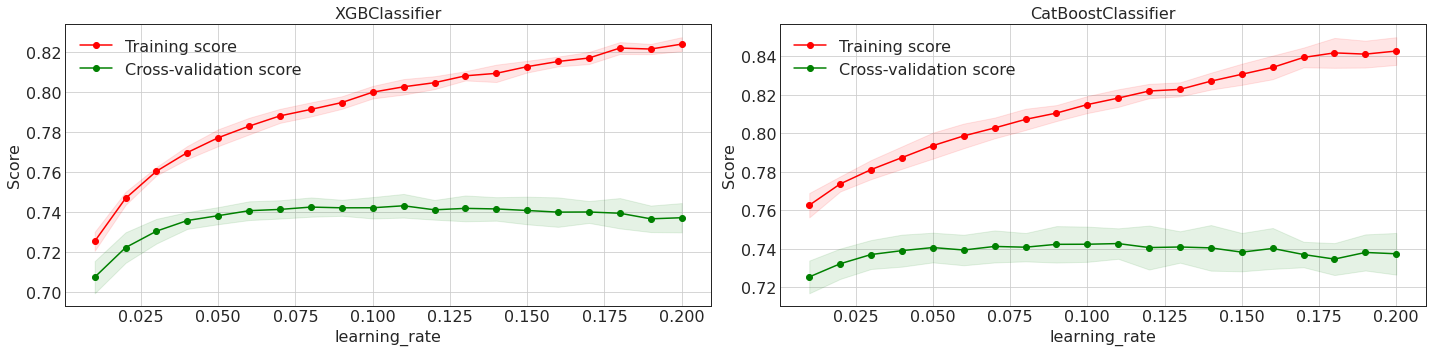

In [ ]:
plot_gsearch_results(selected_models, 'model__learning_rate')

In [ ]:
print_statistics(selected_models, 'learning_rate')

XGBClassifier:
Params №1: params: {'model__learning_rate': 0.11}
           cv-scores before: [0.7382 0.7391 0.7486 0.7486 0.7362], shapiro_pvalue = 0.09
           cv-scores after : [0.7411 0.7409 0.751  0.7483 0.7343], shapiro_pvalue = 0.70
           scores mean: before - 0.7421, now - 0.7431
           scores 0.95 confint: before - [0.7347 0.7496], now - [0.7349 0.7514]
           scores 0.95 confint for diff: [-0.0016  0.0035]
           pvalue for ttest_rel = 0.34

Params №2: params: {'model__learning_rate': 0.08}
           cv-scores before: [0.7382 0.7391 0.7486 0.7486 0.7362], shapiro_pvalue = 0.09
           cv-scores after : [0.7398 0.742  0.7461 0.7491 0.7353], shapiro_pvalue = 0.96
           scores mean: before - 0.7421, now - 0.7425
           scores 0.95 confint: before - [0.7347 0.7496], now - [0.7358 0.7492]
           scores 0.95 confint for diff: [-0.0023  0.003 ]
           pvalue for ttest_rel = 0.74

Params №3: params: {'model__learning_rate': 0.1}
           cv-

Судя по полученным результатам, значение темпа обучения по умолчанию является самым оптимальным.

## max_depth 

Теперь таким же образом подберем максимальную глубину деревьев для бустинга.

In [ ]:
selected_models = ['XGBClassifier', 'CatBoostClassifier']
param_grid = {'model__max_depth': np.arange(2, 11)}
write_gsearch_results(selected_models, X_train, y_train, param_grid, 'max_depth')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.1min finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.1min finished


In [ ]:
save_obj(models, '../data/models_dictionary/models_depth.pkl')

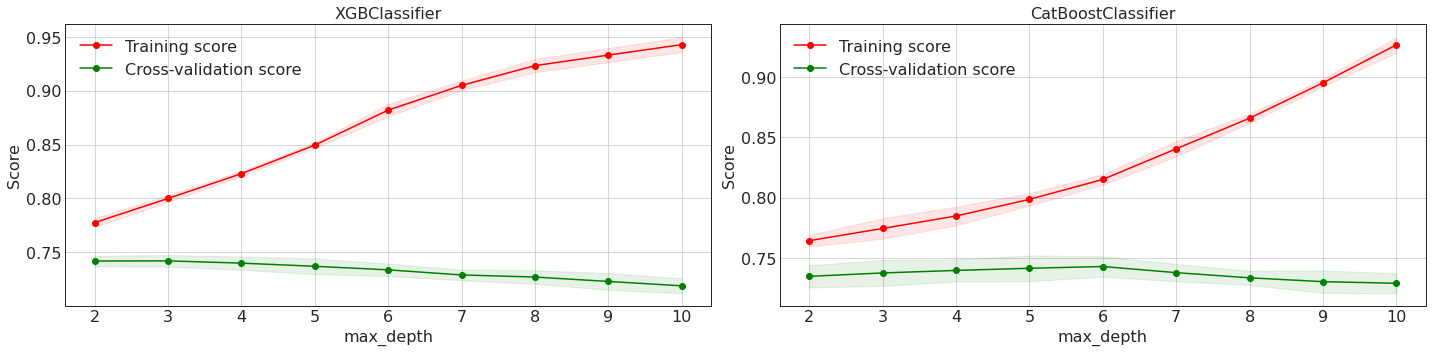

In [ ]:
plot_gsearch_results(selected_models, 'model__max_depth')

In [ ]:
print_statistics(selected_models, 'max_depth')

XGBClassifier:
Params №1: params: {'model__max_depth': 3}
           cv-scores before: [0.7382 0.7391 0.7486 0.7486 0.7362], shapiro_pvalue = 0.09
           cv-scores after : [0.7382 0.7391 0.7486 0.7486 0.7362], shapiro_pvalue = 0.09
           scores mean: before - 0.7421, now - 0.7421
           scores 0.95 confint: before - [0.7347 0.7496], now - [0.7347 0.7496]
           scores 0.95 confint for diff: [0. 0.]
           pvalue for ttest_rel = nan

Params №2: params: {'model__max_depth': 2}
           cv-scores before: [0.7382 0.7391 0.7486 0.7486 0.7362], shapiro_pvalue = 0.09
           cv-scores after : [0.7388 0.7391 0.7432 0.751  0.7377], shapiro_pvalue = 0.11
           scores mean: before - 0.7421, now - 0.7420
           scores 0.95 confint: before - [0.7347 0.7496], now - [0.7352 0.7488]
           scores 0.95 confint for diff: [-0.004   0.0037]
           pvalue for ttest_rel = 0.92

Params №3: params: {'model__max_depth': 4}
           cv-scores before: [0.7382 0.7391 0

Как и в случае с темпом обучения, наиболее оптимальными для обеих моделей являются значения максимальной глубины деревьев по умолчанию.

## min_child_weight

Далее подберем минимальное число объектов в созданном листе дерева для XGBoostClassifier c помощью параметра min_child_weight. Для CatBoostClassifier существует параметр-аналог min_child_samples, но его настройка недоступна для версии модели, которая обучается на gpu.

In [ ]:
param_grid = {'model__min_child_weight': range(10, 201, 10)}
write_gsearch_results(['XGBClassifier'], X_train, y_train, param_grid, 'min_child_weight')

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished


In [ ]:
save_obj(models, '../data/models_dictionary/models_mcw.pkl')

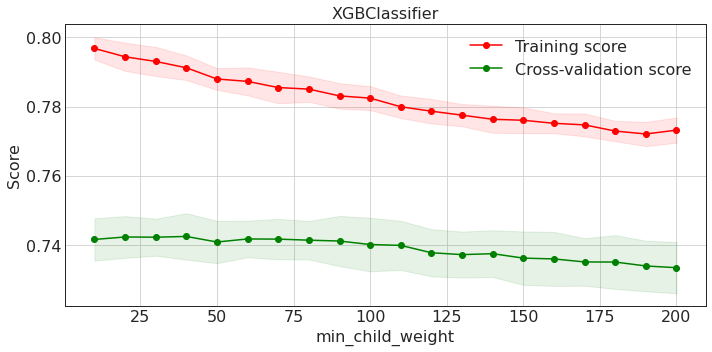

In [ ]:
plot_gsearch_results(['XGBClassifier'], 'model__min_child_weight', figsize=(10, 5))

In [ ]:
print_statistics(['XGBClassifier'], 'min_child_weight')

XGBClassifier:
Params №1: params: {'model__min_child_weight': 40}
           cv-scores before: [0.7382 0.7391 0.7486 0.7486 0.7362], shapiro_pvalue = 0.09
           cv-scores after : [0.7403 0.7396 0.7473 0.7521 0.7327], shapiro_pvalue = 0.87
           scores mean: before - 0.7421, now - 0.7424
           scores 0.95 confint: before - [0.7347 0.7496], now - [0.7331 0.7517]
           scores 0.95 confint for diff: [-0.0032  0.0037]
           pvalue for ttest_rel = 0.84

Params №2: params: {'model__min_child_weight': 20}
           cv-scores before: [0.7382 0.7391 0.7486 0.7486 0.7362], shapiro_pvalue = 0.09
           cv-scores after : [0.74   0.7381 0.7491 0.7495 0.7345], shapiro_pvalue = 0.30
           scores mean: before - 0.7421, now - 0.7422
           scores 0.95 confint: before - [0.7347 0.7496], now - [0.7339 0.7506]
           scores 0.95 confint for diff: [-0.0017  0.0019]
           pvalue for ttest_rel = 0.88

Params №3: params: {'model__min_child_weight': 30}
          

## colsample_bytree

In [ ]:
param_grid = {'model__colsample_bytree': np.round(np.arange(0.5, 1.01, 0.05), 2)}
write_gsearch_results(['XGBClassifier'], X_train, y_train, param_grid, 'colsample_bytree')

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  2.1min finished


In [ ]:
save_obj(models, '../data/models_dictionary/models_colsample.pkl')

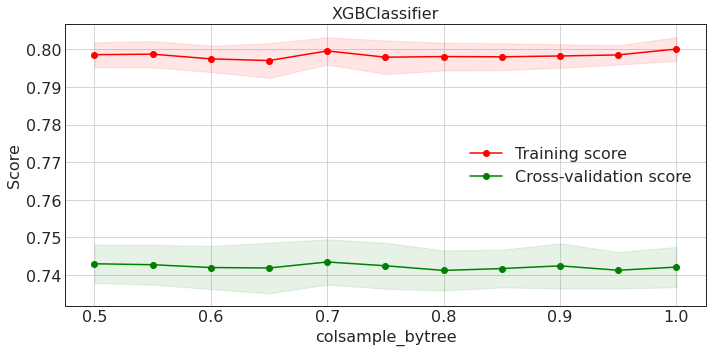

In [ ]:
plot_gsearch_results(['XGBClassifier'], 'model__colsample_bytree', figsize=(10, 5))

In [ ]:
print_statistics(['XGBClassifier'], 'colsample_bytree')

XGBClassifier:
Params №1: params: {'model__colsample_bytree': 0.7000000000000002}
           cv-scores before: [0.7382 0.7391 0.7486 0.7486 0.7362], shapiro_pvalue = 0.09
           cv-scores after : [0.7409 0.7384 0.7503 0.7511 0.7368], shapiro_pvalue = 0.17
           scores mean: before - 0.7421, now - 0.7435
           scores 0.95 confint: before - [0.7347 0.7496], now - [0.7351 0.7518]
           scores 0.95 confint for diff: [-0.0004  0.0031]
           pvalue for ttest_rel = 0.10

Params №2: params: {'model__colsample_bytree': 0.5}
           cv-scores before: [0.7382 0.7391 0.7486 0.7486 0.7362], shapiro_pvalue = 0.09
           cv-scores after : [0.7394 0.7406 0.7486 0.7496 0.7368], shapiro_pvalue = 0.28
           scores mean: before - 0.7421, now - 0.7430
           scores 0.95 confint: before - [0.7347 0.7496], now - [0.7359 0.7501]
           scores 0.95 confint for diff: [0.0001 0.0016]
           pvalue for ttest_rel = 0.03

Params №3: params: {'model__colsample_bytree':

In [ ]:
model = 'XGBClassifier'
pipe = models[model]['pipe']
pipe.set_params(**{'model__colsample_bytree': 0.55})

results = pd.DataFrame(models[model]['colsample_bytree'])
cols = [col for col in results.columns if '_test_score' in col][:-3]
param, best_value = 'model__colsample_bytree', 0.55
actual = results.query(f'param_{param} == {best_value}')[cols].values.flatten()
models[model]['actual'] = actual

## subsample

In [ ]:
param_grid = {'model__subsample': np.round(np.arange(0.5, 1.01, 0.05), 2)}
write_gsearch_results(['XGBClassifier'], X_train, y_train, param_grid, 'subsample')

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  2.1min finished


In [ ]:
save_obj(models, '../data/models_dictionary/models_subsample.pkl')

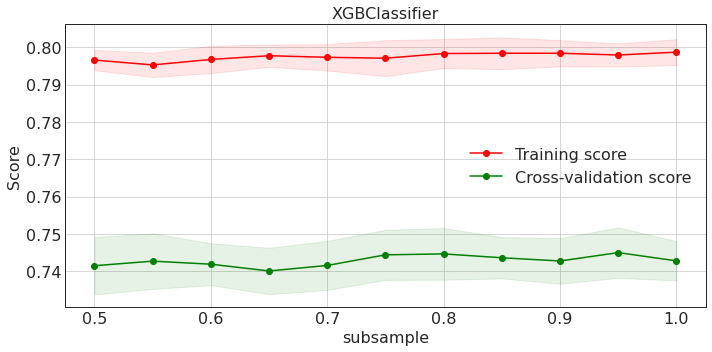

In [ ]:
plot_gsearch_results(['XGBClassifier'], 'model__subsample', figsize=(10, 5))

In [ ]:
print_statistics(['XGBClassifier'], 'subsample')

XGBClassifier:
Params №1: params: {'model__subsample': 0.95}
           cv-scores before: [0.7392 0.7395 0.7493 0.7489 0.7368], shapiro_pvalue = 0.10
           cv-scores after : [0.7403 0.7419 0.7523 0.7537 0.7367], shapiro_pvalue = 0.30
           scores mean: before - 0.7428, now - 0.7450
           scores 0.95 confint: before - [0.7354 0.7501], now - [0.7356 0.7543]
           scores 0.95 confint for diff: [-0.0001  0.0045]
           pvalue for ttest_rel = 0.06

Params №2: params: {'model__subsample': 0.8}
           cv-scores before: [0.7392 0.7395 0.7493 0.7489 0.7368], shapiro_pvalue = 0.10
           cv-scores after : [0.739  0.7404 0.7507 0.755  0.7379], shapiro_pvalue = 0.17
           scores mean: before - 0.7428, now - 0.7446
           scores 0.95 confint: before - [0.7354 0.7501], now - [0.735  0.7542]
           scores 0.95 confint for diff: [-0.0012  0.0049]
           pvalue for ttest_rel = 0.17

Params №3: params: {'model__subsample': 0.75}
           cv-scores befor

In [ ]:
model = 'XGBClassifier'
pipe = models[model]['pipe']
pipe.set_params(**{'model__subsample': 0.95})

results = pd.DataFrame(models[model]['subsample'])
cols = [col for col in results.columns if '_test_score' in col][:-3]
param, best_value = 'model__subsample', 0.95
actual = results.query(f'param_{param} == {best_value}')[cols].values.flatten()
models[model]['actual'] = actual

## reg_lambda

Осуществим процесс подбора коэффициента l2-регуляризации для обеих моделей.

In [ ]:
# сетку значений сгенерируем из равномерного распределения
param_grid = {'model__reg_lambda': [0.0, 1e-8, 1e-4, 1e-2, 1.0, 10.0, 100.0]}

write_gsearch_results(selected_models, X_train, y_train, param_grid, 'reg_lambda')

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.3min finished


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  2.7min finished


In [ ]:
save_obj(models, '../data/models_dictionary/models_reg_lambda.pkl')

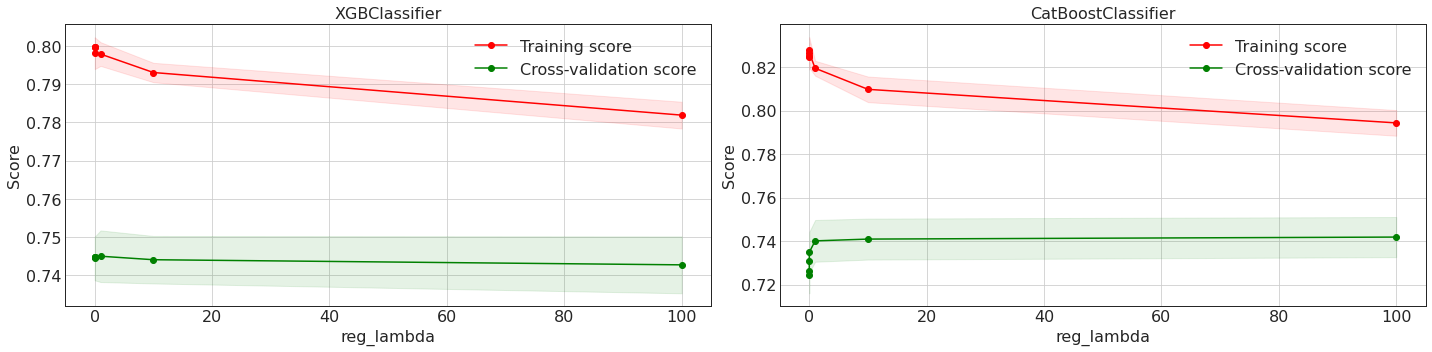

In [ ]:
plot_gsearch_results(selected_models, 'model__reg_lambda')

In [ ]:
print_statistics(selected_models, 'reg_lambda')

XGBClassifier:
Params №1: params: {'model__reg_lambda': 1.0}
           cv-scores before: [0.7403 0.7419 0.7523 0.7537 0.7367], shapiro_pvalue = 0.30
           cv-scores after : [0.7403 0.7419 0.7523 0.7537 0.7367], shapiro_pvalue = 0.30
           scores mean: before - 0.7450, now - 0.7450
           scores 0.95 confint: before - [0.7356 0.7543], now - [0.7356 0.7543]
           scores 0.95 confint for diff: [0. 0.]
           pvalue for ttest_rel = nan

Params №2: params: {'model__reg_lambda': 0.0001}
           cv-scores before: [0.7403 0.7419 0.7523 0.7537 0.7367], shapiro_pvalue = 0.30
           cv-scores after : [0.7406 0.7432 0.7467 0.7541 0.7396], shapiro_pvalue = 0.41
           scores mean: before - 0.7450, now - 0.7449
           scores 0.95 confint: before - [0.7356 0.7543], now - [0.7376 0.7521]
           scores 0.95 confint for diff: [-0.0041  0.0039]
           pvalue for ttest_rel = 0.94

Params №3: params: {'model__reg_lambda': 0.0}
           cv-scores before: [0.7

## n_estimators


In [ ]:
# задаем сетку поиска
param_grid = {'model__n_estimators': np.arange(80, 201, 10)}
write_gsearch_results(selected_models, X_train, y_train, param_grid, 'n_estimators')

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:  2.6min finished


Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:  6.6min finished


In [ ]:
save_obj(models, '../data/models_dictionary/models_n_estimators.pkl')

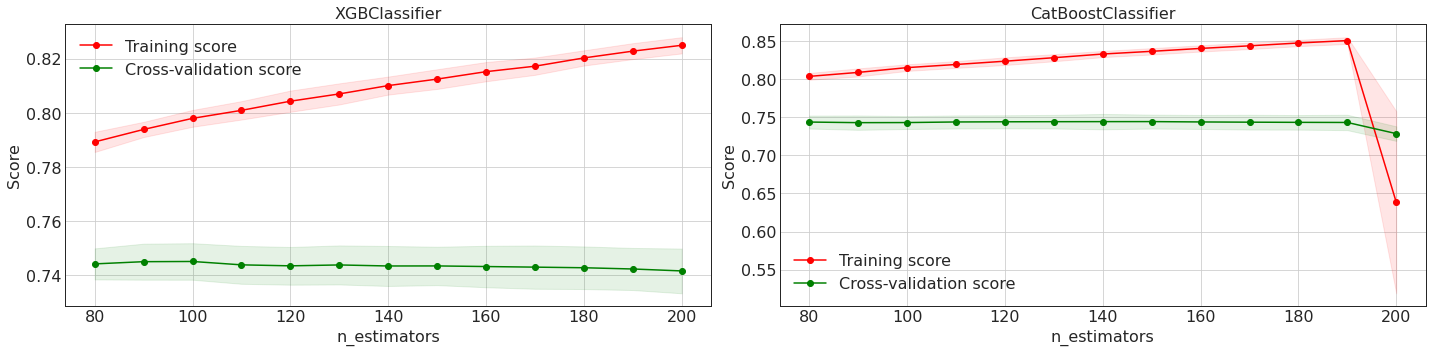

In [ ]:
plot_gsearch_results(selected_models, 'model__n_estimators')

In [ ]:
print_statistics(selected_models, 'n_estimators')

XGBClassifier:
Params №1: params: {'model__n_estimators': 100}
           cv-scores before: [0.7403 0.7419 0.7523 0.7537 0.7367], shapiro_pvalue = 0.30
           cv-scores after : [0.7403 0.7419 0.7523 0.7537 0.7367], shapiro_pvalue = 0.30
           scores mean: before - 0.7450, now - 0.7450
           scores 0.95 confint: before - [0.7356 0.7543], now - [0.7356 0.7543]
           scores 0.95 confint for diff: [0. 0.]
           pvalue for ttest_rel = nan

Params №2: params: {'model__n_estimators': 90}
           cv-scores before: [0.7403 0.7419 0.7523 0.7537 0.7367], shapiro_pvalue = 0.30
           cv-scores after : [0.7401 0.7404 0.7516 0.7542 0.738 ], shapiro_pvalue = 0.13
           scores mean: before - 0.7450, now - 0.7449
           scores 0.95 confint: before - [0.7356 0.7543], now - [0.7356 0.7541]
           scores 0.95 confint for diff: [-0.0014  0.0012]
           pvalue for ttest_rel = 0.88

Params №3: params: {'model__n_estimators': 80}
           cv-scores before: [0.

# Оценка качества на отложенной выборке

In [ ]:
models = load_obj('../data/models_dictionary/models_n_estimators.pkl')

In [ ]:
print('models cv_scores:')
for model in selected_models:
    actual = models[model]['actual']
    print(f'{model} - mean_score = {actual.mean():.4f}, 0.95_confint - {tconfint_mean(actual)}')

models cv_scores:
XGBClassifier - mean_score = 0.7450, 0.95_confint - [0.7356 0.7543]
CatBoostClassifier - mean_score = 0.7430, 0.95_confint - [0.7312 0.7547]


In [ ]:
for model in selected_models:
    pipe = models[model]['pipe']

    if model == 'CatBoostClassifier':
        # передаем в параметры обучения индексы категориальных переменных
        fit_params = {'model__cat_features': categorical_idxs,
                      'model__verbose': False}
        pipe.fit(X_train, y_train, **fit_params);
    else:
        pipe.fit(X_train, y_train)

    models[model]['holdout_probs'] = pipe.predict_proba(X_holdout)

    holdout_score = roc_auc_score(y_holdout,
                                  models[model]['holdout_probs'][:, 1])
    
    print(f'model - {model}, holdout_score = {holdout_score:.4f}')

model - XGBClassifier, holdout_score = 0.7474
model - CatBoostClassifier, holdout_score = 0.7449


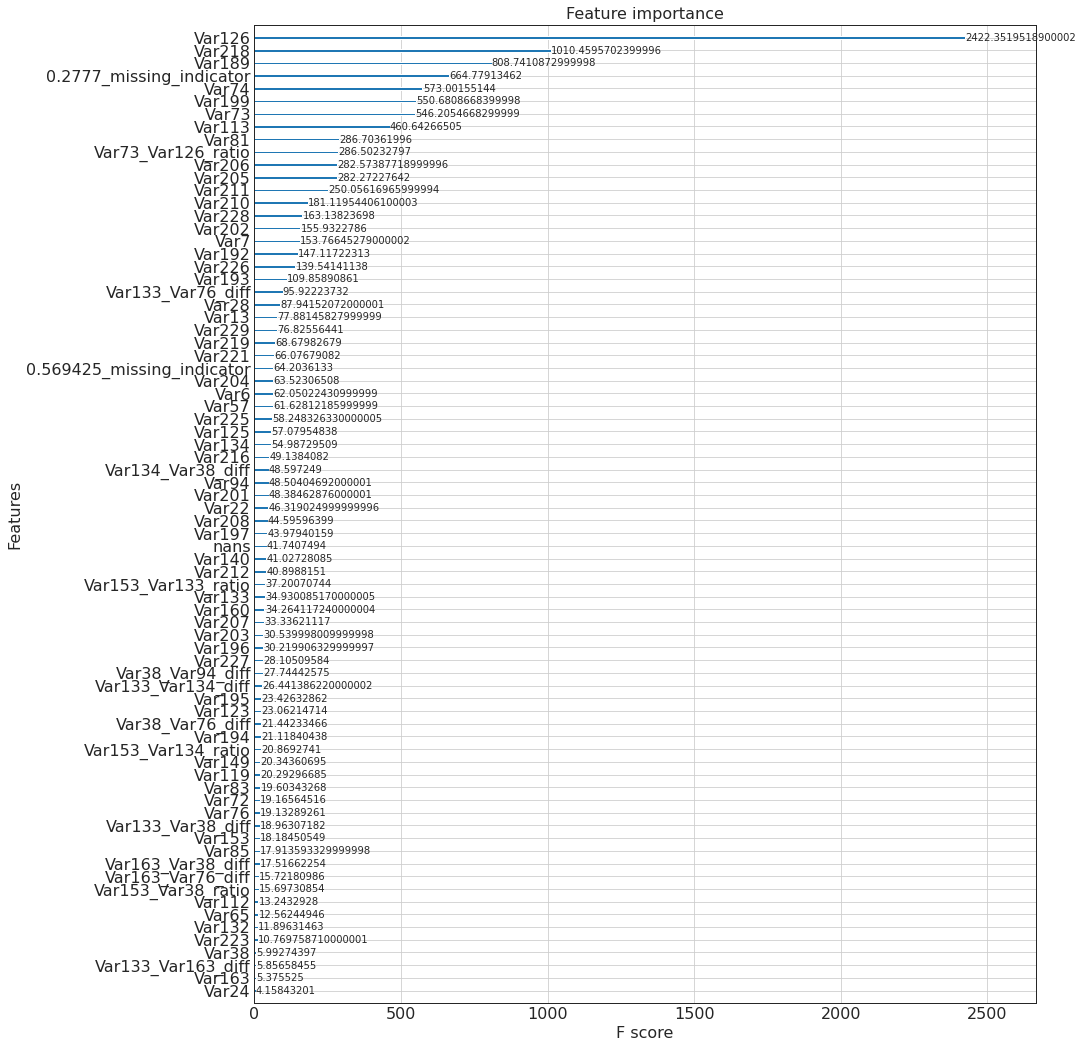

In [ ]:
model = models['XGBClassifier']['pipe'].named_steps['model'].get_booster()
fig, ax = plt.subplots(1, 1, figsize=(14, 18))
model.feature_names = X.columns.to_list()
plot_importance(model, ax=ax, importance_type='total_gain');

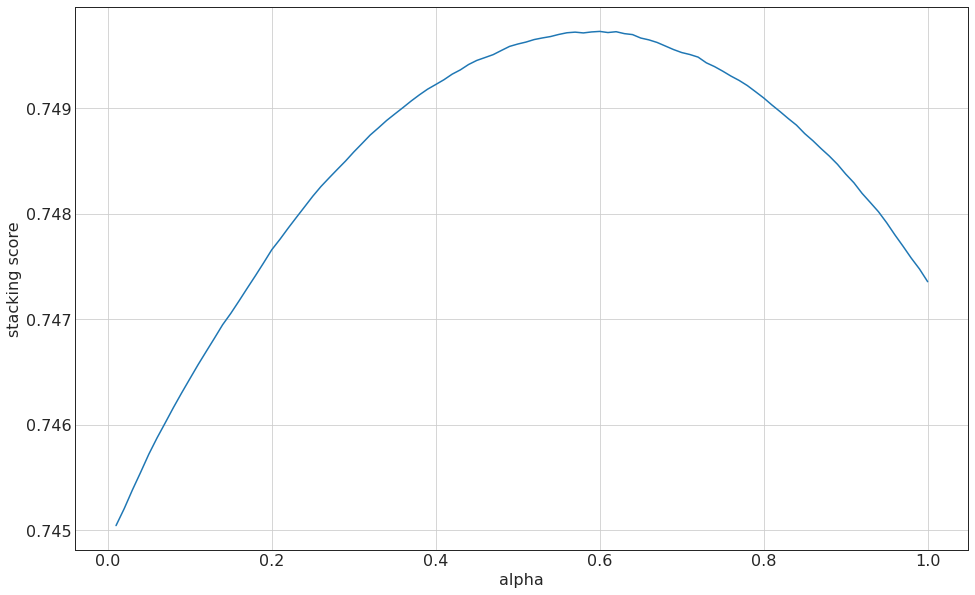

In [ ]:
# создадим простейший стекинг из наших моделей
# вида alpha * alpha*xgb_probs + (1 - alpha)*cat_probs
alphas = np.round(np.arange(0.01, 1.01, 0.01), 2)
xgb_probs = models['XGBClassifier']['holdout_probs']
cat_probs = models['CatBoostClassifier']['holdout_probs']
stacking_probs = [alpha*xgb_probs + (1 - alpha)*cat_probs for alpha in alphas]
stacking_scores = [roc_auc_score(y_holdout, probs[:, 1].flatten()) for probs in stacking_probs]

plt.figure(figsize=(16, 10));
plt.plot(alphas, stacking_scores);
plt.xlabel('alpha');
plt.ylabel('stacking score');
plt.grid();

In [ ]:
# посмотрим на alpha, при котором достигается лучшая
# оценка на отложенной выборке
best_stacking_probs = stacking_probs[np.argmax(stacking_scores)]
alpha = alphas[np.argmax(stacking_scores)]

print(f'stacking with alpha = {alpha}: holdout score - {max(stacking_scores):.4f}')

stacking with alpha = 0.6: holdout score - 0.7497


In [ ]:
# сохраним коэффициент alpha и созданные предсказания вероятностий для стекинга
models['stacking'] = dict()
models['stacking']['alpha'] = alpha
models['stacking']['holdout_probs'] = best_stacking_probs

In [ ]:
save_obj(models, '../data/models_dictionary/models_final.pkl')